In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import numpy as np


from zipfile import ZipFile
import json
from collections import defaultdict

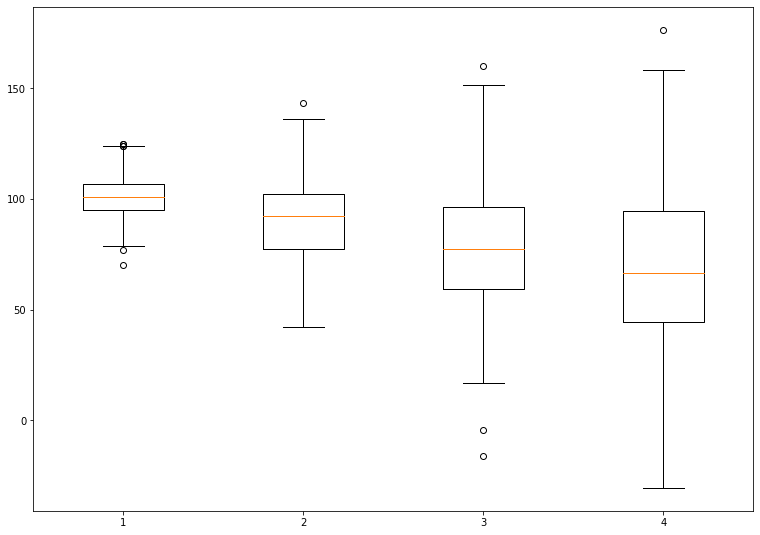

In [2]:

# Creating dataset
np.random.seed(10)
  
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
data = [data_1, data_2, data_3, data_4]
  
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(data)
  
# show plot
plt.show()# Creating dataset
np.random.seed(10)
  
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
data = [data_1, data_2, data_3, data_4]
  
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(data)
  
# show plot
plt.show()

In [3]:
def process_folds(kfolds):
    labels = ['none','sc_guard','oh_verify','cfi_verify']
    result = {}
    for label in labels:
        result[label]=[]
    for fold in kfolds:
        for scores in fold:
            if np.isnan(scores['fscore']):
                continue
            result[scores['label']].append(scores['fscore'])
    return result


def process_results_data(dt, file_path):
    obfuscation = file_path.split('/')[-2].\
        replace('sbb-','').replace('sbb','').replace('-','+').\
        replace('FLAs','CFF').replace('BCF','BC').replace('SUB','IS')
    return {
        'classifier': dt['classifier'],
        'fold_result': process_folds(dt['Kfold_results']),
        'subject_group': dt.get('subject_groups', dt.get('subject_groups_test')),
        'data_size': int(dt['train_size'])+int(dt['test_size']),
        'obfuscation': obfuscation,
        'file_path': file_path
    }


def read_zip_data(zip_path):
    res = []
    with ZipFile(zip_path, 'r') as f_zip:
        for file in f_zip.filelist:
            if 'result.json' in file.filename:
                dt = json.loads(f_zip.read(file))
                res.append(process_results_data(dt, file.filename))
    return res

In [80]:
zip_file_names = {
    'original': 'paperback.zip', 
#     'no_tf_idf': 'paperback_removed_tf_idf.zip', 
    'ir2vec': 'paperback_ir2vec.zip'
}

results_data = []
zips_path = pathlib.Path('/media/nika/TOSHIBA EXT/')
for category, zip_file_name in zip_file_names.items():
    results_data.append({
        'category': category,
        'results': read_zip_data(zips_path / zip_file_name)
    })

In [85]:
data_results = results_data[0]['results']
results_data[0]['category']

'original'

In [86]:
data_results = results_data[1]['results']
results_data[1]['category']

'ir2vec'

In [172]:
def get_plot_results(results_data, protection, filter_data='mibench-cov'):
    """
        {
            # obfuscation --> results
            'None': {
                'original': [0.98, 0.99, 0.99, ...],
                'no_tf_idf': [],
                'ir2vec': []
            },
            'IS': {
                'original': [...],
                'no_tf_idf': [...],
                'ir2vec': [...]
            },
            'FLA': {
                'original': [...],
                'no_tf_idf': [...],
                'ir2vec': [...]
            }
        }
    """
    plot_results = defaultdict(dict)
    for dt in results_data:
        dataset = dt['category']
        for res in dt['results']:
            obfuscation = res['obfuscation']
            if filter_data not in res['file_path']:
                continue

            plot_results[obfuscation][dataset] = res['fold_result'][protection]
    return plot_results

In [173]:
plot_results = get_plot_results(results_data, 'sc_guard')

In [174]:
data_labels = list(plot_results.keys())
data_values_original = [plot_results[label]['original'] for label in data_labels]
data_values_ir2vec = [plot_results[label]['ir2vec'] for label in data_labels]

In [198]:
def draw_plot(data_labels, data_a, data_b, title, file_name):
#     data_a = data_values_original  # [[1,2,5], [5,7,2,2,5], [7,2,5]]
#     data_b = data_values_ir2vec  # [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

    ticks = data_labels # ['A', 'B', 'C']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
    
    figsize_x = 3 if 'simple' in file_name else 4
    plt.figure(figsize=(len(ticks), figsize_x), dpi=200)

    # bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    # bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)


    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a))) - 0.1, sym='', widths=0.1)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b))) + 0.1, sym='', widths=0.1)

    set_box_color(bpl, '#A9A9A9') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#228B22')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#A9A9A9', label='Original')
    plt.plot([], c='#228B22', label='Ir2Vec')
    plt.legend()

    plt.title(title)

    plt.xticks(range(0, len(ticks)), ticks, size=6)
    plt.xlim(-1, len(ticks))
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig(file_name)

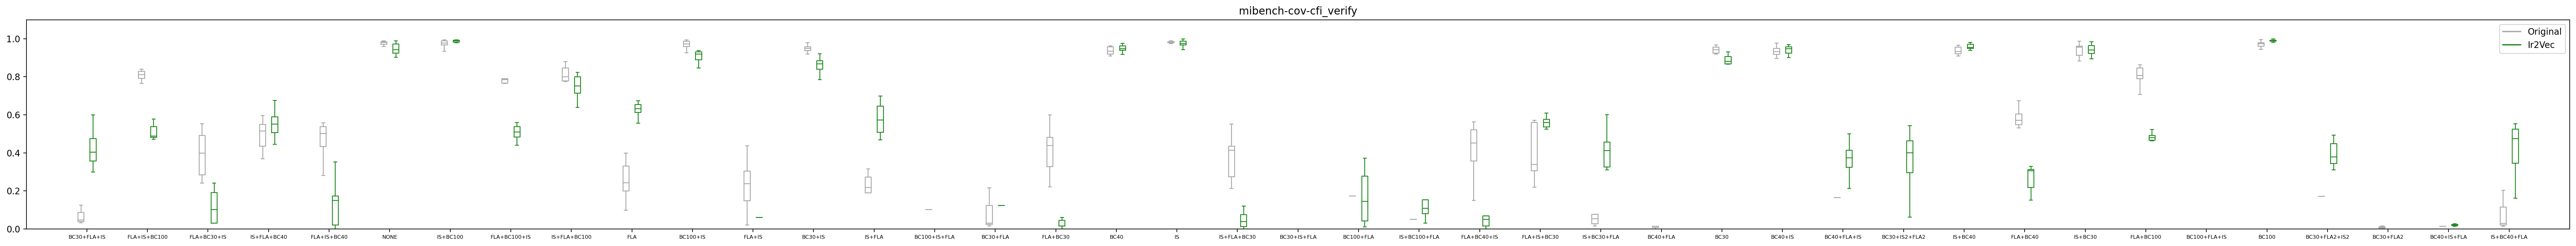

In [199]:
draw_plot(data_labels, data_values_original, data_values_ir2vec, plot_title, file_name)

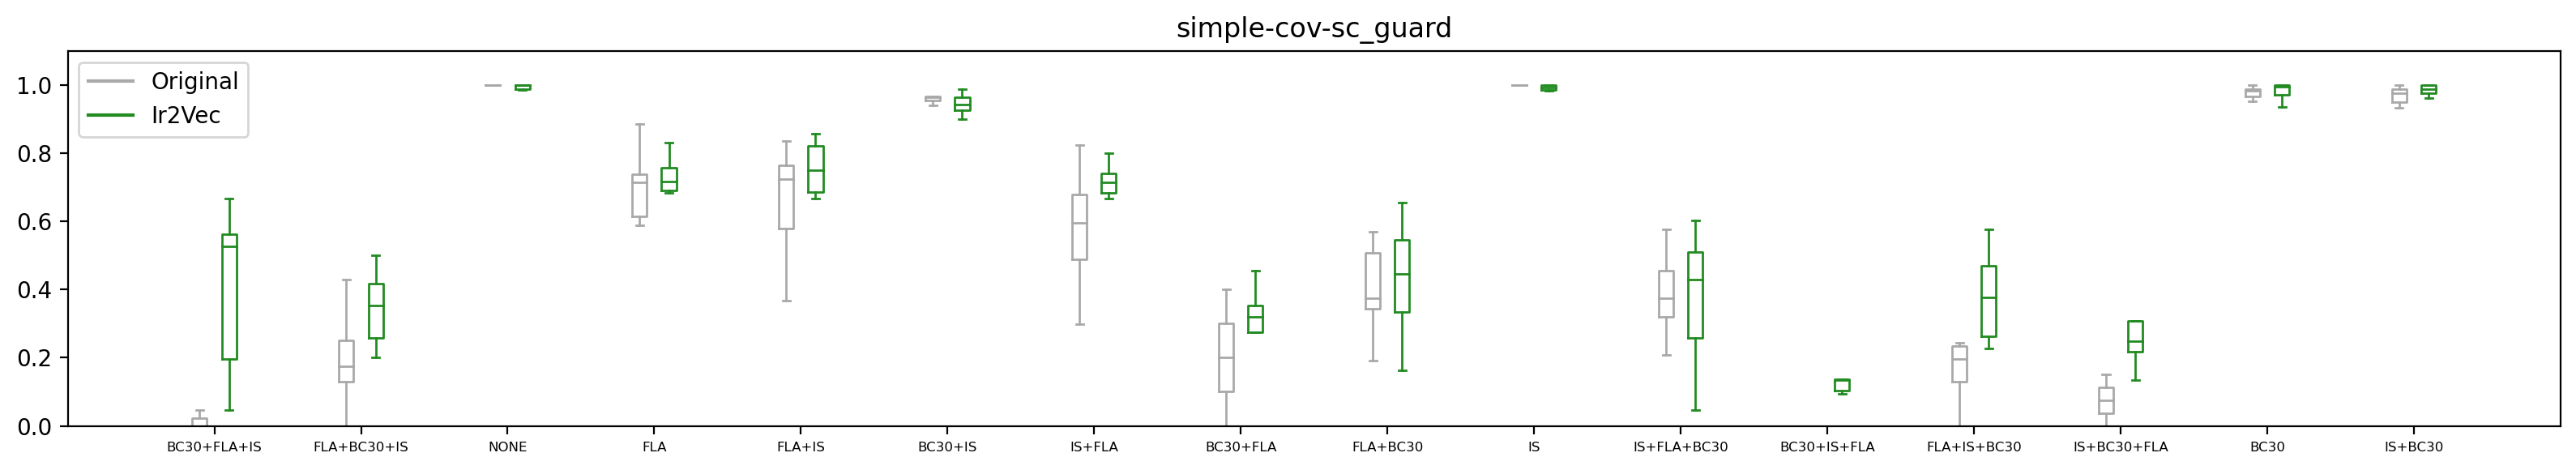

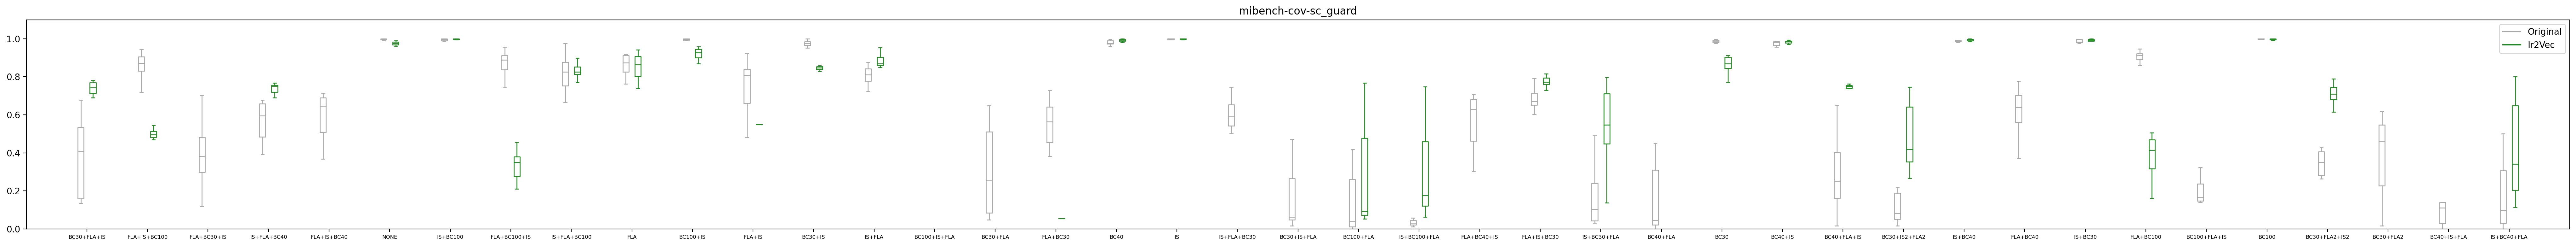

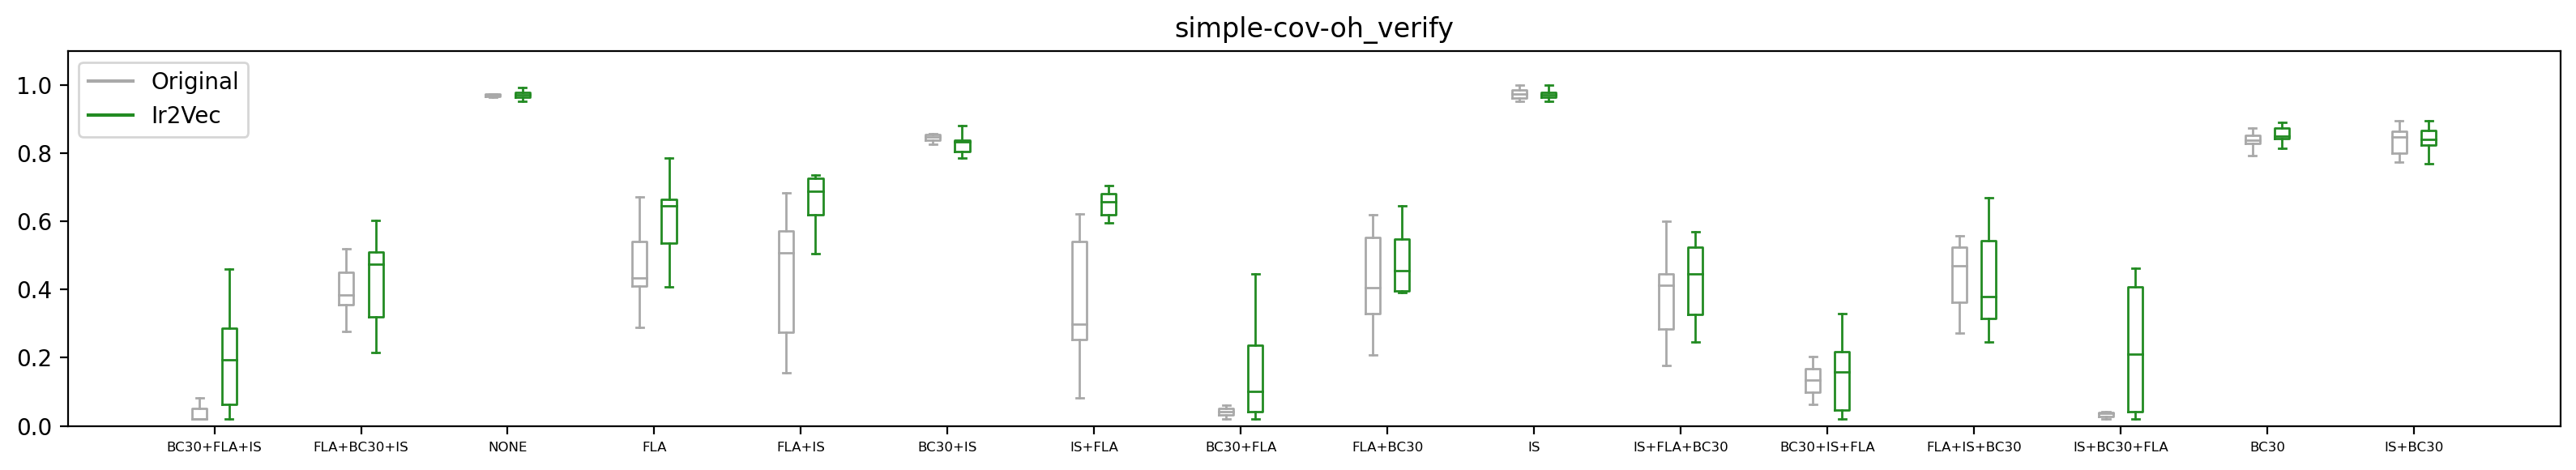

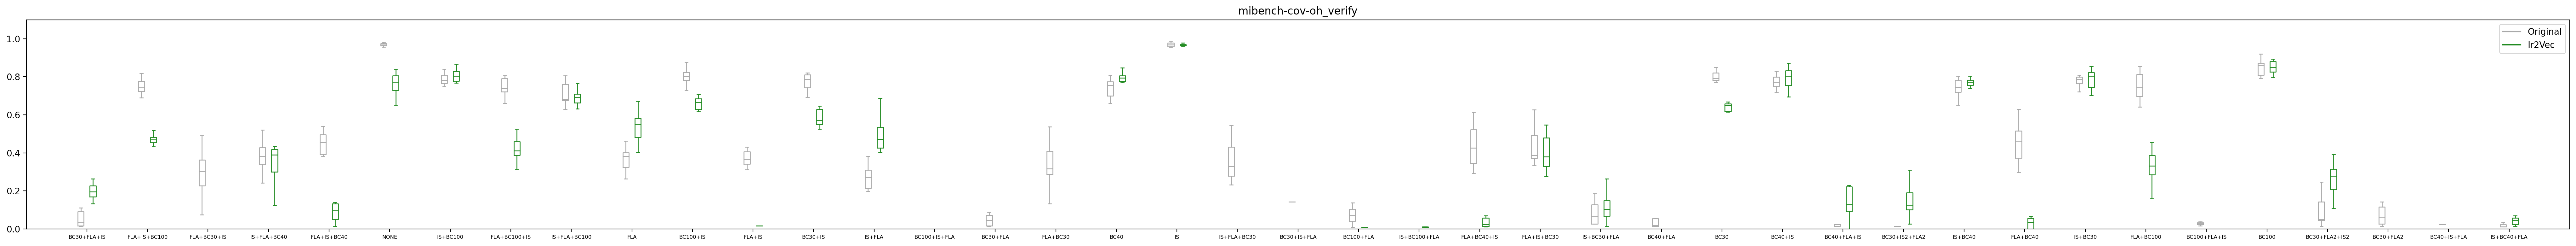

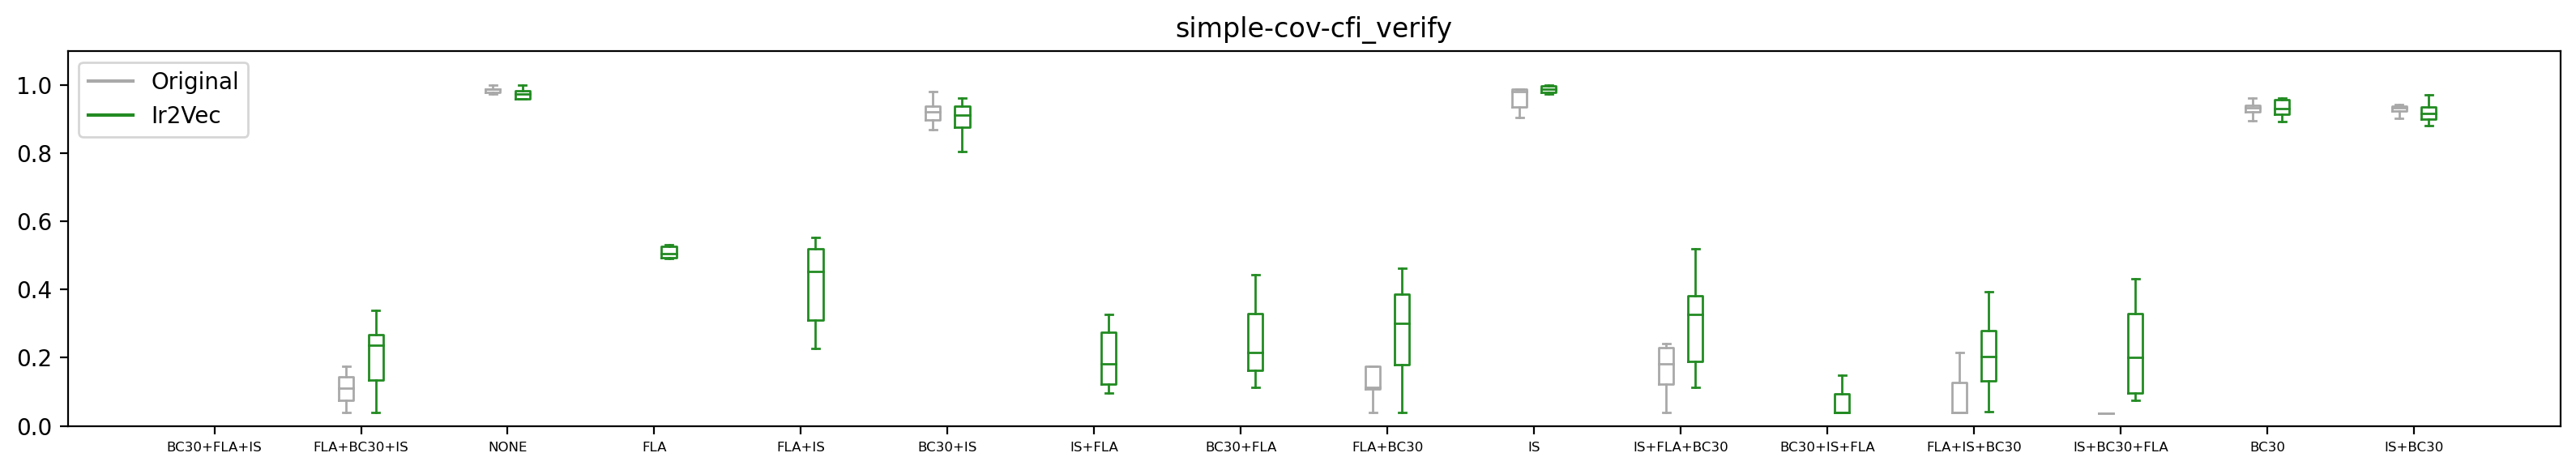

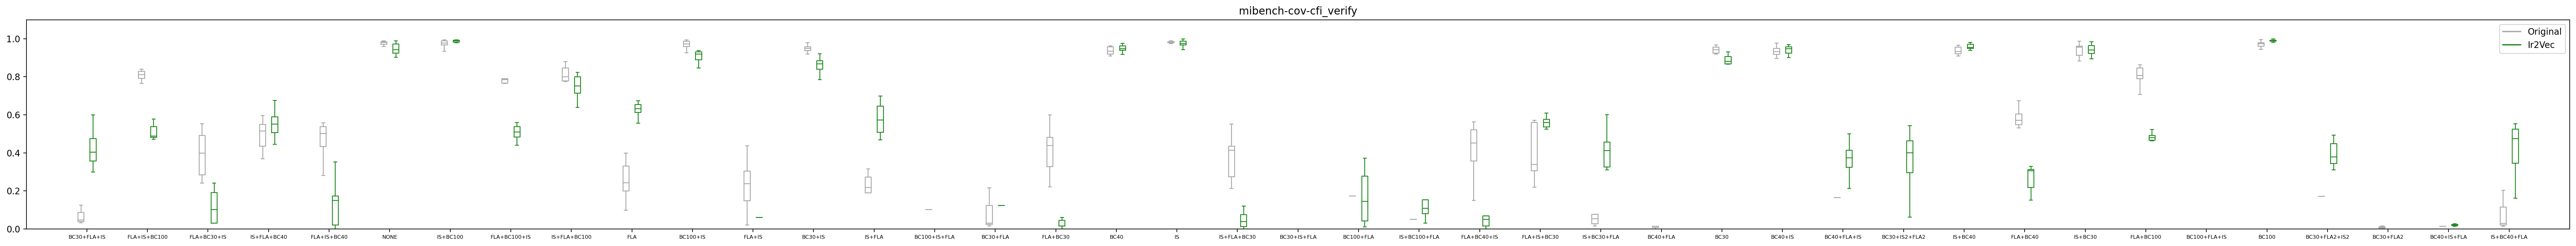

In [200]:
for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
    for src_dataset in ['simple-cov', 'mibench-cov']:
        plot_results = get_plot_results(results_data, protection, src_dataset)
        data_labels = list(plot_results.keys())
        data_values_original = [plot_results[label]['original'] for label in data_labels]
        data_values_ir2vec = [plot_results[label]['ir2vec'] for label in data_labels]
        plot_title = f'{src_dataset}-{protection}'
        file_name = f'plots/{plot_title}.pdf'
        draw_plot(data_labels, data_values_original, data_values_ir2vec, plot_title, file_name)